# Pneumonia datavisualization

This notebook will work on given dataset and try to retreive key points of interests inside of it

**Main goals are**: 

- Display image
- Reshape image without loss of important data
- Determining important data
- Treat and format the dataset

**Loading dataset sample from local source**

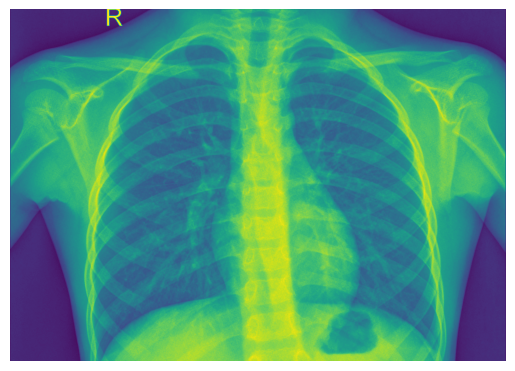

In [48]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Open the image
image_path = "../../datasets/chest_Xray/raw_data/IM-0001-0001.jpeg"  # Sample image
img = mpimg.imread(image_path)

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

## Now we try to convert all images so they get the same size

**Finding a common height and width**

In [55]:
#Start by retreiving dataset information into a single dataframe

import os
from PIL import Image
import pandas as pd

# Create a DataFrame from a dictionary
data = {'width': [],
        'height': []}

imgs_size_df = pd.DataFrame(data)
imgs_folder = "../../datasets/chest_Xray/raw_data"

# Get all image file names
image_files = [f for f in os.listdir(imgs_folder) if os.path.isfile(os.path.join(imgs_folder, f))]

# Add each sizes to dataframe
for image_file in image_files:
    with Image.open(os.path.join(imgs_folder, image_file)) as img:
        width, height = img.size
        new_sample = {'width': width, 'height': height}
        imgs_size_df.loc[len(imgs_size_df)] = new_sample

imgs_size_df

,width,height
0,1857,1317
1,2111,1509
2,2031,1837
3,1663,1326
4,2053,1818
...,...,...
5851,1414,882
5852,1256,696
5853,1152,856
5854,1248,728


**Plotting width and height distribution to get better intuition on dataset**

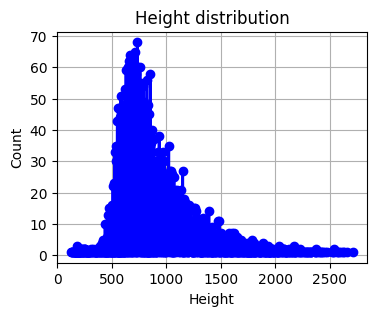

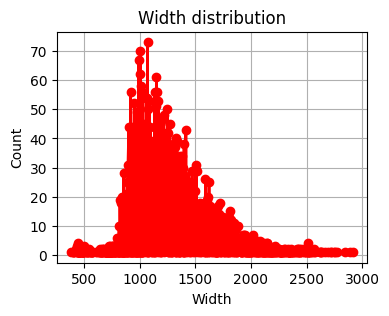

In [63]:
import matplotlib.pyplot as plt

#Group values to see the representation
grouped_height = imgs_size_df.groupby('height').size().reset_index(name='count')
grouped_width = imgs_size_df.groupby('width').size().reset_index(name='count')


# Plot spline chart
plt.figure(figsize=(4, 3))
plt.plot(grouped_height['height'], grouped_height['count'], marker='o', linestyle='-', color='b', linewidth=2)
plt.title('Height distribution')
plt.xlabel('Height')
plt.ylabel('Count')
plt.grid(True)
plt.show()

# Plot spline chart
plt.figure(figsize=(4, 3))
plt.plot(grouped_width['width'], grouped_width['count'], marker='o', linestyle='-', color='r', linewidth=2)
plt.title('Width distribution')
plt.xlabel('Width')
plt.ylabel('Count')
plt.grid(True)
plt.show()

**Calculating mean values**

In [71]:
# Width analysis

mean_width = imgs_size_df['width'].mean().round(2)
min_width = imgs_size_df['width'].min().round(2)
max_width = imgs_size_df['width'].max().round(2)
std_width = imgs_size_df['width'].std().round(2)

print("The width is around " + str(mean_width) + "px with " + str(std_width) + "px standard deviation")
print("     (min val is " + str(min_width) + "px with " + str(max_width) + "px max val)")
print("     (common val could be around " + str(mean_width + std_width) + "px)")

The width is around 1327.88px with 363.5px standard deviation
     (min val is 384px with 2916px max val)
     (common val could be around 1691.38px)


In [73]:
# Height analysis

mean_height = imgs_size_df['height'].mean().round(2)
min_height = imgs_size_df['height'].min().round(2)
max_height = imgs_size_df['height'].max().round(2)
std_height = imgs_size_df['height'].std().round(2)

print("The height is around " + str(mean_height) + "px with " + str(std_height) + "px standard deviation")
print("     (min val is " + str(min_height) + "px with " + str(max_height) + "px max val)")
print("     (common val could be around " + str(mean_height + std_height) + "px)")

The height is around 970.69px with 383.39px standard deviation
     (min val is 127px with 2713px max val)
     (common val could be around 1354.08px)


In [74]:
common_width = 1700
common_height = 1350

### **From now on the size of images will be set to constant values :**
-  Width = 1700px
-  Height = 1350px

(One std from mean to maximize size without getting biased by extremes values)

### Resizing images

In [194]:
# Setting a max iter for test purpose
max_iter = 75

**Adding black around smaller data to not loose data**

In [195]:
import os
import pandas as pd
from PIL import Image

def resize_image(image_path, size):
    """
    Resize the image to the specified size without changing aspect ratio.
    """
    img = Image.open(image_path)
    img.thumbnail(size, Image.LANCZOS)
    background = Image.new('RGB', size, (0, 0, 0))  # Black background
    background.paste(img, ((size[0] - img.size[0]) // 2, (size[1] - img.size[1]) // 2))
    return background

def image_to_dataframe(image):
    """
    Convert an image to a DataFrame representing its grayscale values.
    """
    img_gray = image.convert("L")
    data = list(img_gray.getdata())
    df = pd.DataFrame(data, columns=["Pixel_Value"])
    return df

def process_images(imgs_folder, dest_folder_img, dest_folder_dfs):
    """
    Process all images in the given folder.
    """
    # Get all image file names
    image_files = [f for f in os.listdir(imgs_folder) if os.path.isfile(os.path.join(imgs_folder, f))]
    
    # Find the size of the largest image
    max_width = common_width
    max_height = common_height
    
    n_iter = 0
    # Process each image
    for image_file in image_files:
        if(n_iter >= max_iter):
            break
        n_iter += 1
        with Image.open(os.path.join(imgs_folder, image_file)) as img:
            # Resize the image
            img_resized = resize_image(os.path.join(imgs_folder, image_file), (max_width, max_height))
            
            # Convert the resized image to grayscale DataFrame
            df = image_to_dataframe(img_resized)
            
            # Save the processed image
            img_resized.save(os.path.join(dest_folder_img, "processed_img_" + image_file))
            # Optionally, you can save the DataFrame to a CSV file
            df.to_csv(os.path.join(dest_folder_dfs, "processed_df_" + image_file.split('.')[0] + ".csv"), index=False)


# Set source and destination folders
imgs_folder = "../../datasets/chest_Xray/raw_data"
dest_folder_img = "../../datasets/chest_Xray/_processed_black_add/_processed_imgs"
dest_folder_dfs = "../../datasets/chest_Xray/_processed_black_add/_processed_dfs"

# Create destination folder if it doesn't exist
if not os.path.exists(dest_folder_img):
    os.makedirs(dest_folder_img)

if not os.path.exists(dest_folder_dfs):
    os.makedirs(dest_folder_dfs)

# Process images
process_images(imgs_folder, dest_folder_img, dest_folder_dfs)

In [196]:
# Using a nice ploting lib
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

csv_files = [f for f in os.listdir(dest_folder_dfs) if os.path.isfile(os.path.join(dest_folder_dfs, f))]

images_sum = pd.DataFrame()

for csv_file in csv_files:
    csv_path = os.path.join(dest_folder_dfs, csv_file)
    df = pd.read_csv(csv_path)
    if images_sum.empty:
        images_sum = df
    else:
        images_sum += df

Max pixel value for 75 iterations is 16269


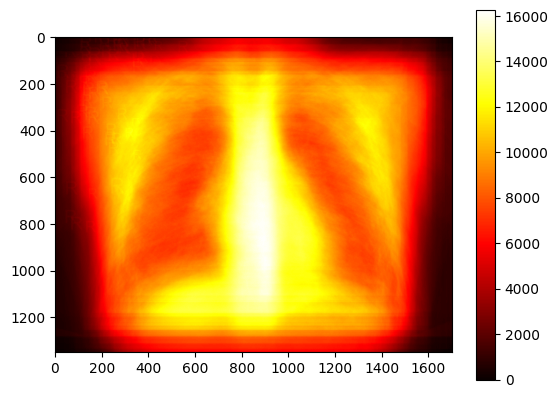

In [197]:
image = images_sum.values.reshape(common_height, common_width)
print("Max pixel value for " + str(max_iter) + " iterations is " + str(image.max()))
plt.imshow(image, cmap='hot')
plt.colorbar()

### Plot look like a squared x-ray lungs<br>
Data may have encountered bad transformation

**Tryning to distort images** <br>
We assume that all images are barely the same regardless of images size, so distorting it shouldn't biases our data

In [111]:
import os
import pandas as pd
from PIL import Image

def resize_image(image_path, size):
    """
    Resize the image to the specified size while keeping the aspect ratio.
    """
    img = Image.open(image_path)
    img_resized = img.resize(size, Image.LANCZOS)
    return img_resized

def image_to_dataframe(image):
    """
    Convert an image to a DataFrame representing its grayscale values.
    """
    img_gray = image.convert("L")
    data = list(img_gray.getdata())
    df = pd.DataFrame(data, columns=["Pixel_Value"])
    return df

def process_images(imgs_folder, dest_folder_img, dest_folder_dfs):
    """
    Process all images in the given folder.
    """
    # Get all image file names
    image_files = [f for f in os.listdir(imgs_folder) if os.path.isfile(os.path.join(imgs_folder, f))]
    
    # Find the size of the largest image
    max_width = common_width
    max_height = common_height
    
    # n_iter = 0
    # Process each image
    for image_file in image_files:
        # if(n_iter >= max_iter):
        #     break
        # n_iter += 1
        with Image.open(os.path.join(imgs_folder, image_file)) as img:
            # Resize the image
            img_resized = resize_image(os.path.join(imgs_folder, image_file), (max_width, max_height))
            
            # Convert the resized image to grayscale DataFrame
            df = image_to_dataframe(img_resized)
            
            # Save the processed image
            img_resized.save(os.path.join(dest_folder_img, "processed_img_" + image_file))
            # Optionally, you can save the DataFrame to a CSV file
            df.to_csv(os.path.join(dest_folder_dfs, "processed_df_" + image_file.split('.')[0] + ".csv"), index=False)


# Set source and destination folders
imgs_folder = "../../datasets/chest_Xray/raw_data"
dest_folder_img = "../../datasets/chest_Xray/_processed_resize/_processed_imgs"
dest_folder_dfs = "../../datasets/chest_Xray/_processed_resize/_processed_dfs"

# Create destination folder if it doesn't exist
if not os.path.exists(dest_folder_img):
    os.makedirs(dest_folder_img)

if not os.path.exists(dest_folder_dfs):
    os.makedirs(dest_folder_dfs)

# Process images
process_images(imgs_folder, dest_folder_img, dest_folder_dfs)

**Images are resized and an uncompressed version is saved as a csv file**<br>
Now we check wich is the most effective for reading data

**Using csv files**

In [141]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import time

start_time = time.time()

dest_folder_dfs = "../../datasets/chest_Xray/_processed_resize/_processed_dfs"

csv_files = [f for f in os.listdir(dest_folder_dfs) if os.path.isfile(os.path.join(dest_folder_dfs, f))]

images_sum = pd.DataFrame()

print("Max iter :" + str(max_iter))

n_iter = 0
for csv_file in csv_files:
    if(n_iter >= max_iter):
        break
    n_iter += 1
    csv_path = os.path.join(dest_folder_dfs, csv_file)
    df = pd.read_csv(csv_path)
    if images_sum.empty:
        images_sum = df
    else:
        images_sum += df


end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Max iter :100
Execution time: 14.656809091567993 seconds


**Using images files**

In [140]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import time

start_time = time.time()

dest_folder_imgs = "../../datasets/chest_Xray/_processed_resize/_processed_imgs"

img_files = [f for f in os.listdir(dest_folder_imgs) if os.path.isfile(os.path.join(dest_folder_imgs, f))]

images_sum = pd.DataFrame()

print("Max iter :" + str(max_iter))

n_iter = 0
for img_file in img_files:
    if(n_iter >= max_iter):
        break
    n_iter += 1
    img_path = os.path.join(dest_folder_imgs, img_file)
    
    with Image.open(img_path) as img:
        df = image_to_dataframe(img)
        if images_sum.empty:
            images_sum = df
        else:
            images_sum += df


end_time = time.time()

execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Max iter :100
Execution time: 31.650587558746338 seconds


### **!! As CSV usage is more efficient we will use it from now !!**

In [144]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import time

start_time = time.time()

dest_folder_dfs = "../../datasets/chest_Xray/_processed_resize/_processed_dfs"

csv_files = [f for f in os.listdir(dest_folder_dfs) if os.path.isfile(os.path.join(dest_folder_dfs, f))]

images_sum = pd.DataFrame()
max_iter = 500
print("Max iter :" + str(max_iter))

n_iter = 0
for csv_file in csv_files:
    if(n_iter >= max_iter):
        break
    n_iter += 1
    csv_path = os.path.join(dest_folder_dfs, csv_file)
    df = pd.read_csv(csv_path)
    if images_sum.empty:
        images_sum = df
    else:
        images_sum += df


end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")

Max iter :500
Execution time: 75.7340099811554 seconds


Max value is 104788


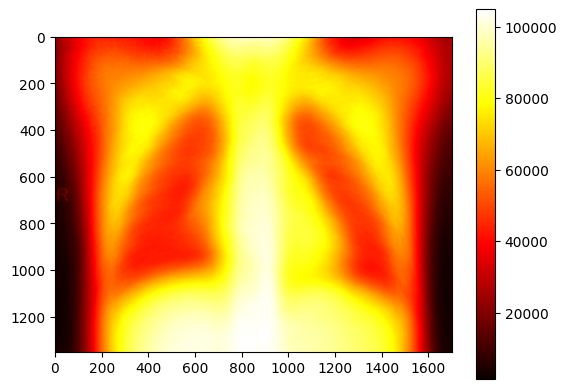

In [145]:
image = images_sum.values.reshape(common_height, common_width)
print("Max value is " + str(image.max()))
plt.imshow(image, cmap='hot')
plt.colorbar()

### **Proportions looks good**, we may have found a good way to format all data so they have the same size

We start looking at wich region of the image could be deleted to prevent bad interpretation

## Trying to find a suitable mask to erase useless data

In [157]:
image_adjusted = images_sum.copy()
image_adjusted.max()

Pixel_Value    104788
dtype: int64

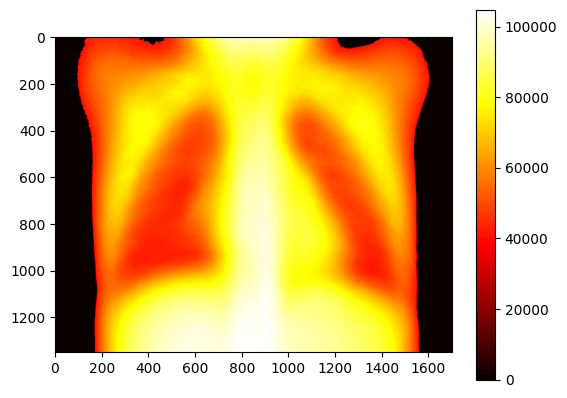

In [160]:
image_adjusted[image_adjusted < 41000] = 0


image_cropped = image_adjusted.values.reshape(common_height, common_width)

df = pd.DataFrame(image_cropped)
df = df.clip(lower=None, upper=1)
df.to_csv(os.path.join("../../datasets/chest_Xray/_processed_resize/", "data_mask_seuil.csv"), index=False)

plt.imshow(image_cropped, cmap='hot')
plt.colorbar()

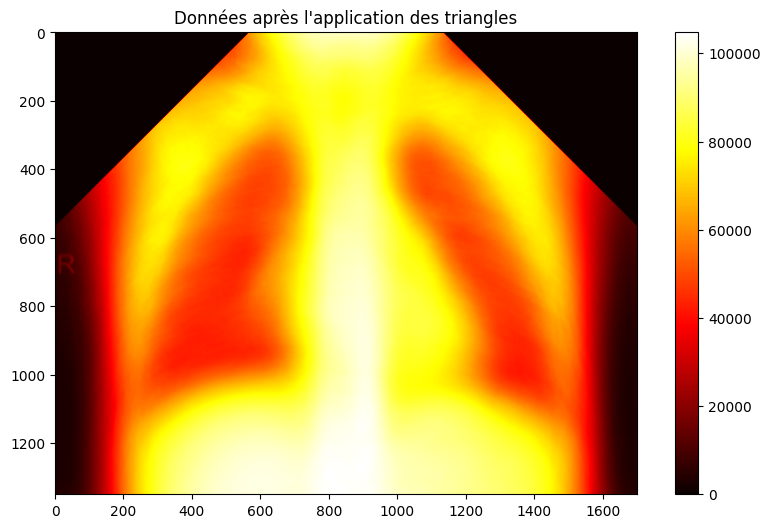

In [163]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

def determinant(p1, p2, p):
    return (p2[0] - p1[0]) * (p[1] - p1[1]) - (p[0] - p1[0]) * (p2[1] - p1[1])


def adapt_triangle(tableau, s1, s2, s3):
    rows = len(tableau)
    columns = len(tableau[0])
    
    for i in range(rows):
        for j in range(columns):

            coord = (i, j)
            

            det1 = determinant(s1, s2, coord)
            det2 = determinant(s2, s3, coord)
            det3 = determinant(s3, s1, coord)

            if (det1 >= 0 and det2 >= 0 and det3 >= 0) or (det1 <= 0 and det2 <= 0 and det3 <= 0):
                tableau[i][j] = 0

    return tableau


# Exemple d'utilisation :
data =  images_sum.copy().values.reshape(common_height, common_width)

result = adapt_triangle(data,(0, 0), (0, common_width/3), (common_width/3, 0))
result = adapt_triangle(data,(0, (common_width/3)*2), (0, common_width), (common_width/3, common_width))

df = pd.DataFrame(result)
df = df.clip(lower=None, upper=1)
df.to_csv(os.path.join("../../datasets/chest_Xray/_processed_resize/", "data_mask_triangle.csv"), index=False)

# Affichage du résultat avec Matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(result, cmap='hot')
plt.colorbar()
plt.title('Données après l\'application des triangles')
plt.show()

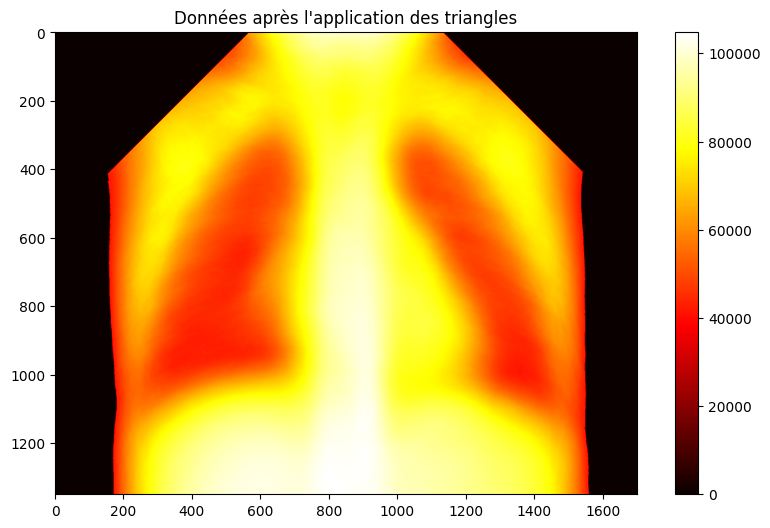

In [165]:
data =  image_cropped.copy()

result = adapt_triangle(data,(0, 0), (0, common_width/3), (common_width/3, 0))
result = adapt_triangle(data,(0, (common_width/3)*2), (0, common_width), (common_width/3, common_width))

df = pd.DataFrame(result)
df = df.clip(lower=None, upper=1)
df.to_csv(os.path.join("../../datasets/chest_Xray/_processed_resize/", "data_mask_seuil_triangle.csv"), index=False)


# Affichage du résultat avec Matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(result, cmap='hot')
plt.colorbar()
plt.title('Données après l\'application des triangles')
plt.show()

### Trying our masks on sample data

**Raw data**

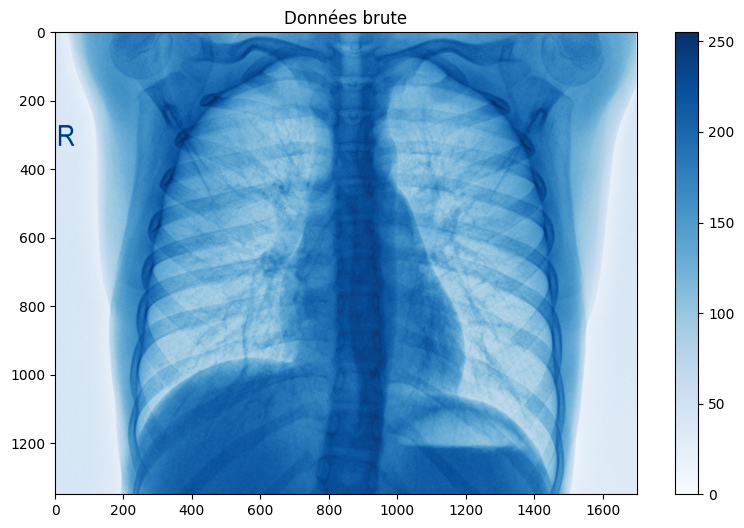

In [179]:
array_image = pd.read_csv('../../datasets/chest_Xray/_processed_resize/_processed_dfs/processed_df_IM-0003-0001.csv')
array_image = array_image.values.reshape(common_height, common_width)

plt.figure(figsize=(10, 6))
plt.imshow(array_image, cmap='Blues')
plt.colorbar()
plt.title('Données brute')
plt.show()

**Seuil mask**

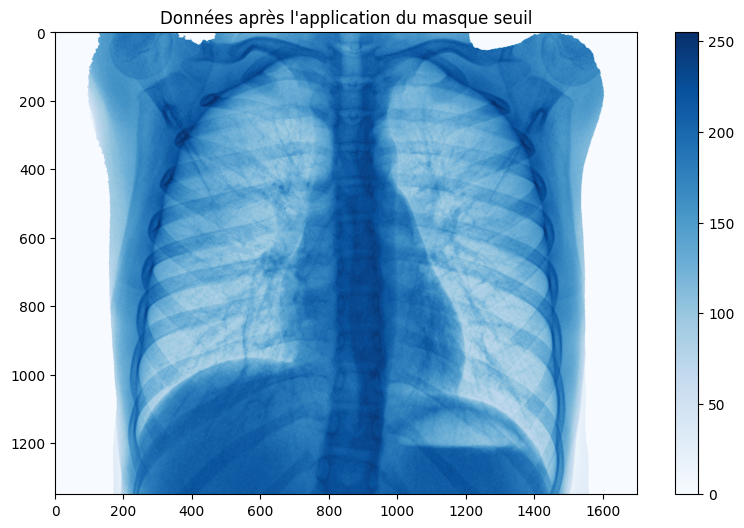

In [178]:
mask = pd.read_csv("../../datasets/chest_Xray/_processed_resize/data_mask_seuil.csv") 
array_image = pd.read_csv('../../datasets/chest_Xray/_processed_resize/_processed_dfs/processed_df_IM-0003-0001.csv')
array_image = array_image.values.reshape(common_height, common_width)
masked_image_array = np.where(mask == 1, array_image, 0)

plt.figure(figsize=(10, 6))
plt.imshow(masked_image_array, cmap='Blues')
plt.colorbar()
plt.title('Données après l\'application du masque seuil')
plt.show()

**Triangle mask**

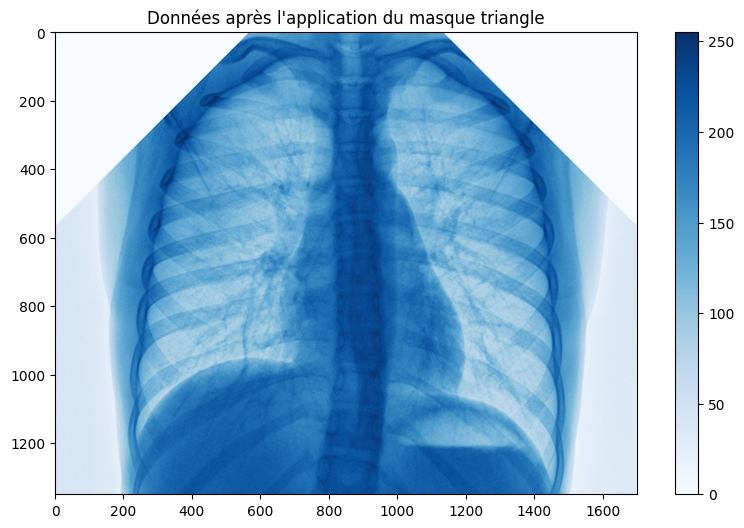

In [181]:
mask = pd.read_csv("../../datasets/chest_Xray/_processed_resize/data_mask_triangle.csv") 
array_image = pd.read_csv('../../datasets/chest_Xray/_processed_resize/_processed_dfs/processed_df_IM-0003-0001.csv')
array_image = array_image.values.reshape(common_height, common_width)
masked_image_array = np.where(mask == 1, array_image, 0)

plt.figure(figsize=(10, 6))
plt.imshow(masked_image_array, cmap='Blues')
plt.colorbar()
plt.title('Données après l\'application du masque triangle')
plt.show()

**Combined mask**

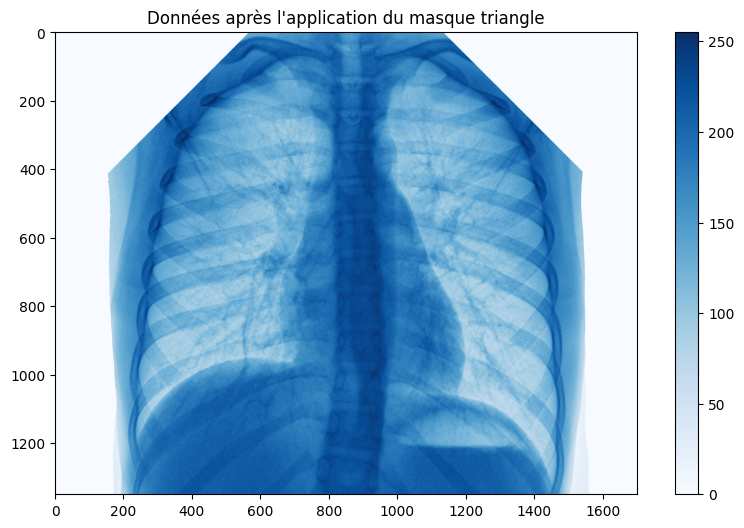

In [182]:
mask = pd.read_csv("../../datasets/chest_Xray/_processed_resize/data_mask_seuil_triangle.csv") 
array_image = pd.read_csv('../../datasets/chest_Xray/_processed_resize/_processed_dfs/processed_df_IM-0003-0001.csv')
array_image = array_image.values.reshape(common_height, common_width)
masked_image_array = np.where(mask == 1, array_image, 0)

plt.figure(figsize=(10, 6))
plt.imshow(masked_image_array, cmap='Blues')
plt.colorbar()
plt.title('Données après l\'application du masque triangle')
plt.show()

## Seems we found a good way to isolate meaningfull data without loosing too much informations